In [1]:
import numpy as np
from numpy import sin as Sin
from numpy import cos as Cos

from scipy.optimize import minimize
from scipy import linalg

import matplotlib.pyplot as plt
plt.style.use('paper.mplstyle')

from qiskit import Aer, execute, ClassicalRegister, QuantumRegister, QuantumCircuit, IBMQ

In [2]:
# IBMQ.enable_account('d3b7c023279124bef090f1c314bad06fa60a55a8f115891b5790d1cec64d9219056ee2d051f795b7d6f24373b145b5409be2ac00b8326141d723cebf3dfc2f58')
# IBMQ.save_account('d3b7c023279124bef090f1c314bad06fa60a55a8f115891b5790d1cec64d9219056ee2d051f795b7d6f24373b145b5409be2ac00b8326141d723cebf3dfc2f58')
provider = IBMQ.load_account()

/Users/jlazar/anaconda3/envs/qiskit/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# As a first step, we will discuss fitting the PMNS matrix via likelihood minimization

We need to fit the six parameters from the paper to match the measured values of the PMNS matrix, given by 

$$
\begin{pmatrix}
    0 & 0 & 0 & 0\\
    0 & 0 & 0 & 0\\
    0 & 0 & 0 & 0\\
    0 & 0 & 0 & 1\\
\end{pmatrix}
$$

To do this, we must first define a likelihood, which must have the proporty that it attains a glabal minimum when the parameters take on the correct value. One way we can achieve this is by using a method inspired by the least squared method. 

## Least squares likelihood

If we denote the measured PMNS matrix as $U_{\rm{PMNS}}$ and the matrix want to fit it to as $V$, one possible likelihood choice is given by:

$$
\mathcal{L} = \sum_{i,j=1}^{4}\left|U_{{\rm{PMNS}},\, ij}-V_{ij}\right|
$$

This is strictly non-negative since it is a sum of square real numbers, and it achives the global minimum of 0 exactly when each element of $V$ is equal to each member of $U_{\rm{PMNS}}$.

## Define functions for each element of the parametrized matrix
Don't do this by hand. Copy and paste this from me or use Mathematica

In [3]:
paper_PMNS_dagger_params = (-0.6031, 7.412-4*np.pi, 0.7966,  1.0139, 0.7053, -8.065+4*np.pi)
paper_PMNS_params        = (-0.7053, -1.3599,       0.7966, -1.0139, 0.6031,  2.0125)

In [4]:
def V11(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(beta/2.)*(Cos(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.) - Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.)) + \
           Sin(alpha/2.)*(-(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.)) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.))) + \
           Cos(beta/2.)*(-(Sin(alpha/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.) + Cos((epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
           Cos(alpha/2.)*(Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Cos(zeta/2.) + Sin(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [5]:
def V21(alpha, beta, gamma, delta, epsilon, zeta):
    return Cos(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon + gamma)/2.) - Cos((alpha - epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
           Sin(beta/2.)*(-(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.) + Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.))) - \
           Cos(alpha/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [6]:
def V31(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(alpha/2.)*(-(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.) + Cos((epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
           Cos(beta/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) - Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.))) + \
           Cos(alpha/2.)*(Cos(delta/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(beta/2.) + Cos(beta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
           Sin(delta/2.)*(-(Cos(beta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.)) + Sin(beta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [7]:
def V41(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon - gamma)/2.) - Cos((alpha - epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
           Cos(beta/2.)*(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.) + Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
           Cos(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [8]:
def V12(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Cos(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon + gamma)/2.) + Cos((alpha - epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
           Sin(beta/2.)*(Sin(alpha/2.)*(-(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.)) + Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.)) + \
           Cos(alpha/2.)*(-(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.)) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [9]:
def V22(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(beta/2.)*(-(Cos(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.) + Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.))) + \
           Sin(alpha/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.))) + \
           Cos(beta/2.)*(Sin(alpha/2.)*(-(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.)) + Cos((epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
           Cos(alpha/2.)*(Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Cos(zeta/2.) - Sin(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [10]:
def V32(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon - gamma)/2.) + Cos((alpha - epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
           Cos(beta/2.)*(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.) - Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
           Cos(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) - Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [11]:
def V42(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Sin(alpha/2.)*(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.) - Cos((epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
           Cos(beta/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))) + \
           Cos(alpha/2.)*(Cos(delta/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(beta/2.) + Cos(beta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
           Sin(delta/2.)*(Cos(beta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.) - Sin(beta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.))) 

In [12]:
def V13(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(alpha/2.)*(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.) + Cos((epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
           Cos(beta/2.)*(-(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.)) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.))) - \
           Cos(alpha/2.)*(Cos(delta/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(beta/2.) + Cos(beta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.)) + \
           Sin(delta/2.)*(-(Cos(beta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.)) + Sin(beta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [13]:
def V23(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon + gamma)/2.) - Cos((alpha - epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
           Cos(beta/2.)*(-(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.) + Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.))) - \
           Cos(alpha/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [14]:
def V33(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Sin(beta/2.)*(Cos(alpha/2.)*(-(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.)) + Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
            Sin(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) - Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))) + \
            Cos(beta/2.)*(-(Sin(alpha/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.) + Cos((epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
            Cos(alpha/2.)*(Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Cos(zeta/2.) + Sin(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [15]:
def V43(alpha, beta, gamma, delta, epsilon, zeta):
    return Cos(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon - gamma)/2.) - Cos((alpha - epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) - \
            Sin(beta/2.)*(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.) + Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
            Cos(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [16]:
def V14(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon + gamma)/2.) + Cos((alpha - epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
            Cos(beta/2.)*(Sin(alpha/2.)*(-(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.)) + Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.)) +\
            Cos(alpha/2.)*(-(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.)) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [17]:
def V24(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(alpha/2.)*(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.) - Cos((epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
            Cos(beta/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.))) - \
            Cos(alpha/2.)*(Cos(delta/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(beta/2.) + Cos(beta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.)) + \
            Sin(delta/2.)*(Cos(beta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.) - Sin(beta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [18]:
def V34(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Cos(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon - gamma)/2.) + Cos((alpha - epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) - \
            Sin(beta/2.)*(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.) - Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
            Cos(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) - Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [19]:
def V44(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Sin(beta/2.)*(Cos(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.) + Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) - \
            Sin(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))) + \
            Cos(beta/2.)*(Sin(alpha/2.)*(-(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.)) + Cos((epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
            Cos(alpha/2.)*(Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Cos(zeta/2.) - Sin(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

## Now we gather up all these functions and put them in a nice matrix form

In [20]:
def V(params):
    return np.array([
                     [V11(*params), V12(*params), V13(*params), V14(*params)],
                     [V21(*params), V22(*params), V23(*params), V24(*params)],
                     [V31(*params), V32(*params), V33(*params), V34(*params)],
                     [V41(*params), V42(*params), V43(*params), V44(*params)],
                    ]
                   )

Define the measured PMNS matrix

In [23]:
np.matrix(V((-0.6031, 7.412, 0.7966, 1.0139, 0.7053, -8.065)))

matrix([[ 8.21326729e-01,  1.49719299e-01,  5.50460294e-01,
          2.35963697e-05],
        [ 3.05724247e-01,  6.99142635e-01, -6.46322084e-01,
          1.58188277e-04],
        [-4.81617160e-01,  6.99130655e-01,  5.28451727e-01,
          1.03753524e-04],
        [-1.77728437e-05, -1.86666274e-04,  3.44229840e-05,
          9.99999982e-01]])

In [25]:
U_PMNS = np.array([
                   [ 0.821327, 0.149719,  0.55046,  0.0],
                   [ 0.305724, 0.699143, -0.646322, 0.0],
                   [-0.481617, 0.699131,  0.528452, 0.0],
                   [ 0.0,      0.0,       0.0,      1.0]
                  ]
                 )

## Define likelihood described above

In [26]:
def matrix_likelihood(params, target_matrix):
    # make a box
    if np.any([p>2*np.pi for p in params]):
        value = np.inf
    elif np.any([p<-2*np.pi for p in params]):
        value = np.inf
    else:
        mat   = V(tuple(params))
        value = np.sum([np.abs(np.abs(mat[i,j]-target_matrix[i,j])) for i in range(4)
                                                                    for j in range(4)]
                 )
    return value

We must provide a starting point in the paramter space to the minimizer. In general, we would like this to be reasonably close to the best fit point. In order to find a decent starting position, we can pick $n$ positions randomly, and then pick the one that gives us the minimum likelihood value.

In [27]:
# randomly select set of params
n_guesses                   = 10000
first_guesses               = [tuple(2*np.pi*(2*np.random.rand((6))-1)) for i in range(n_guesses)]
llhs                        = [matrix_likelihood(guess, U_PMNS) for guess in first_guesses] # evaluate likelihood for each guess
sorted_llhs, sorted_guesses = zip(*sorted(zip(llhs, first_guesses)))
best_guess                  = np.array(sorted_guesses[0]) # pick the guess that gave the lowest likelihood value
result                      = minimize(matrix_likelihood, best_guess, method='L-BFGS-B', args=U_PMNS) # run the minimizer starting from the best guess
print('Relative error for each entry')
print((V(result.x)-U_PMNS)/U_PMNS)
print(r'The best fit parameters are $\alpha$=%s, $\beta$=%s, $\gamma$=%s, $\delta$=%s, $\epsilon$=%s, $\zeta$=%s' % tuple(result.x))

Relative error for each entry
[[ 0.02531034 -0.26918514 -0.05602584         inf]
 [-0.35052454  0.19174485 -0.2098194          inf]
 [ 0.03407663 -0.24148109  0.29092404         inf]
 [       -inf        -inf        -inf -0.00992454]]
The best fit parameters are $\alpha$=5.517624327850232, $\beta$=4.181646690144831, $\gamma$=5.625401285879329, $\delta$=0.6972102545020419, $\epsilon$=-5.544855395828485, $\zeta$=1.4109411388973476


/Users/jlazar/anaconda3/envs/qiskit/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-27-ec065afb7fbd>:9: RuntimeWarning: divide by zero encountered in true_divide
  print((V(result.x)-U_PMNS)/U_PMNS)


# Error evaluation

Easy peasy. Now let's move on to thinking about choosing a good basis. This comes down to a choice of basis vectors. Before we were using the convention:

\begin{align}
\left|\nu_{1}\right> = \begin{pmatrix}1\\0\\0\\0\end{pmatrix} \qquad \left|\nu_{2}\right> = \begin{pmatrix}0\\1\\0\\0\end{pmatrix} \qquad \left|\nu_{3}\right> = \begin{pmatrix}0\\0\\1\\0\end{pmatrix},
\end{align}

but this was an arbitrary choice, and infinitely many other choices are available, some of which may result in fewer errors.

As a reminder, errors come from an accidental bit flip, which can happen with some probability which we measure empirically. We will label the probability of an accidental bit flip in the first and second qubits $p_{1}$ and $p_{2}$ respectively. For now, I will just take the numbers given in Carlos' paper and we can make our own measurement independently, \textit{i.e.} we will set $p_{1}$=0.13 and $p_{1}$=0.03.

Our strategy will be:

1) Pick a random set of basis vectors.

2) Run our quantum code using the quantum simulator.

3) Probabilistically flip some of the bits from the results according to our $p$s


4) Repeat many times, assessing the level of error for each, and find which set of basis vectors give the smallest error

## 1) Basis vectors

The two rules of basis vectors are 1) they must be orthogonal. 2) They must have modulus of 1. Since these are very common conditions in physics, we say that a set of vectors that meets both is \textit{orthonormal}. Given an arbitrary set of vectors, we can create a set of vectors that abide by these conditions using the Gram-Schmidt procedure.

In [26]:
def norm(vector):
    vector= np.array(vector)
    return np.sqrt(np.sum(vector*vector))

def gram_schmidt(vectors):
    assert(vectors.shape[0]==vectors.shape[1])
    result = np.zeros(vectors.shape)
    for i, vec0 in enumerate(vectors):
        tmp = vec0
        for vec in result[:i]:
            tmp = tmp-np.dot(vec, vec0)*vec
        result[i] = tmp/norm(tmp)
    return result

## Let's do this by choosing some random angles

In [42]:
gs_vectors = np.zeros((4,4))
vectors           = (np.random.rand(9)-0.5).reshape(3,3) # Generate some random numbers
gs_vectors[:3,:3] = gram_schmidt(vectors)
gs_vectors[3,3]   = 1
U_PMNS_prime = np.matmul(gs_vectors, U_PMNS.T)
print(U_PMNS_prime)

[[-6.71607169e-01 -7.28306887e-01 -1.36062726e-01  1.45173821e-04]
 [-5.69519820e-01  3.90005916e-01  7.23562967e-01 -1.23327753e-04]
 [ 4.73910346e-01 -5.63440050e-01  6.76715726e-01  7.73550670e-06]
 [ 2.35964000e-05  1.58188000e-04  1.03754000e-04  1.00000000e+00]]


Actually I think we can just represent the with some rotations

In [144]:
def rotate_basis(i, j, theta, x):
    x = np.array(x)
    n = x.shape[0]
    if i>j: # swap the value to make sure function is symmetric in i,j
        i,j = j,i
    # construct rotation array
    c = np.cos(theta)
    s = np.sin(theta)
    rot = np.zeros((n,n))
    np.fill_diagonal(rot, 1)
    rot[i,i] =  c
    rot[j,j] =  c
    rot[i,j] =  s
    rot[j,i] = -s
    return np.matmul(rot, x)

## 2) Run on a quantum simulator

Now we have a new basis selected, which ultimately gives us a different representation on the PMNS matrix. Thus we must fit a new set of parameters that we can enter into our simulator.

There is speed trade off with the number of inital guesses, we make. If we guess a lot we are likely to end up near the correct minimum, but guessing a lot means that we need to evaluate the likelihood many times, which takes awhile. Let's find the best number oif initial guesses

In [32]:
tno.qreg.name

'q120'

In [96]:
import time
fit_succeeded = True
for n_guesses in np.logspace(1,3,11):
    nsuc      = 0
    t0        = time.time()
    n_guesses = int(n_guesses)
    while nsuc<10:
        if fit_succeeded:
            ndim  = 3
            basis = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
            ths   = {}
            for i in range(ndim):
                for j in range(ndim):
                    if i<j:
                        th = np.random.rand()*2*np.pi
                        ths[(i,j)] = th
                        basis = rotate_basis(i, j, th, basis)
            U_PMNS_prime = np.matmul(U_PMNS, basis)
            fit_succeeded = False


        # randomly select set of params
        first_guesses               = [tuple(2*np.pi*(2*np.random.rand((6))-1)) for i in range(n_guesses)]
        llhs                        = [matrix_likelihood(guess, U_PMNS_prime) for guess in first_guesses] # evaluate likelihood for each guess
        sorted_llhs, sorted_guesses = zip(*sorted(zip(llhs, first_guesses)))
        best_guess                  = np.array(sorted_guesses[0]) # pick the guess that gave the lowest likelihood value
        PMNS_fit                    = minimize(matrix_likelihood, best_guess, method='L-BFGS-B', tol=1e-15, args=U_PMNS_prime) # run the minimizer starting from the best guess
        PMNS_params                 = PMNS_fit.x
        PMNS_dagger_params          = (-PMNS_params[4],-PMNS_params[5],-PMNS_params[2],-PMNS_params[3],-PMNS_params[0],-PMNS_params[1],)
    #     print(r'The best fit parameters are $\alpha$=%s, $\beta$=%s, $\gamma$=%s, $\delta$=%s, $\epsilon$=%s, $\zeta$=%s' % tuple(PMNS_params))

        rel_error   = np.abs((V(PMNS_params)-U_PMNS_prime)/U_PMNS_prime)
        finite_mask = np.where(np.isfinite(rel_error))
        big_error   = np.max(rel_error[finite_mask])


        tol = 1e-4
#         tol = 1e-5
        if big_error < tol:
            nsuc += 1
            fit_succeeded = True
    t1 = time.time()
    print('Took %f seconds to successfully minimize 10 times with %d guesses' % (t1-t0, n_guesses))

<ipython-input-96-38db116f58ef>:32: RuntimeWarning: divide by zero encountered in true_divide
  rel_error   = np.abs((V(PMNS_params)-U_PMNS_prime)/U_PMNS_prime)


Took 32.061920 seconds to successfully minimize 10 times with 10 guesses
Took 41.131687 seconds to successfully minimize 10 times with 15 guesses
Took 25.944666 seconds to successfully minimize 10 times with 25 guesses
Took 28.050352 seconds to successfully minimize 10 times with 39 guesses
Took 33.554384 seconds to successfully minimize 10 times with 63 guesses
Took 20.736510 seconds to successfully minimize 10 times with 100 guesses
Took 181.896417 seconds to successfully minimize 10 times with 158 guesses
Took 35.059435 seconds to successfully minimize 10 times with 251 guesses
Took 34.132148 seconds to successfully minimize 10 times with 398 guesses
Took 48.277939 seconds to successfully minimize 10 times with 630 guesses
Took 293.355885 seconds to successfully minimize 10 times with 1000 guesses


It looks like 63 is a pretty good number. Let's start with that and we can refine it later if we want

In [97]:
# Create a new basis
ndim  = 3
basis = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
ths   = {}
for i in range(ndim):
    for j in range(ndim):
        if i<j:
            th = np.random.rand()*2*np.pi
            ths[(i,j)] = th
            basis = rotate_basis(i, j, th, basis)
U_PMNS_prime = np.matmul(U_PMNS, basis)

# Fit the parameters
n_guesses = 63
fit_succeeded = False
while not fit_succeeded:
    # randomly select set of params
        first_guesses               = [tuple(2*np.pi*(2*np.random.rand((6))-1)) for i in range(n_guesses)]
        llhs                        = [matrix_likelihood(guess, U_PMNS_prime) for guess in first_guesses] # evaluate likelihood for each guess
        sorted_llhs, sorted_guesses = zip(*sorted(zip(llhs, first_guesses)))
        best_guess                  = np.array(sorted_guesses[0]) # pick the guess that gave the lowest likelihood value
        PMNS_fit                    = minimize(matrix_likelihood, best_guess, method='L-BFGS-B', tol=1e-15, args=U_PMNS_prime) # run the minimizer starting from the best guess
        PMNS_params                 = PMNS_fit.x
        PMNS_dagger_params          = (-PMNS_params[4],-PMNS_params[5],-PMNS_params[2],-PMNS_params[3],-PMNS_params[0],-PMNS_params[1],)
    #     print(r'The best fit parameters are $\alpha$=%s, $\beta$=%s, $\gamma$=%s, $\delta$=%s, $\epsilon$=%s, $\zeta$=%s' % tuple(PMNS_params))

        rel_error   = np.abs((V(PMNS_params)-U_PMNS_prime)/U_PMNS_prime)
        finite_mask = np.where(np.isfinite(rel_error))
        big_error   = np.max(rel_error[finite_mask])


        tol = 1e-4
        if big_error < tol:
            fit_succeeded = True

<ipython-input-97-7bce9662b1ad>:27: RuntimeWarning: divide by zero encountered in true_divide
  rel_error   = np.abs((V(PMNS_params)-U_PMNS_prime)/U_PMNS_prime)


We have a set of parameters for our propagation, so now let's propagate

In [21]:
from three_neutrino import ThreeNuOscillator

In [22]:
loee = np.linspace(0, 1200, 21)
n = 10000
sim_results = np.zeros((4,len(loee)))
for i, LE in enumerate(loee):
    tno = ThreeNuOscillator('numu')
    tno.apply_rotation(param=paper_PMNS_params)
    tno.propagate(LE)
    tno.apply_rotation(param=paper_PMNS_dagger_params)
    tno.measure()
    job = execute(tno.qc, Aer.get_backend('qasm_simulator'), shots=n)
    counts = job.result().get_counts(tno.qc)
    for j, (key, val) in enumerate(sorted(counts.items())):
        sim_results[j, i] = float(val)/n



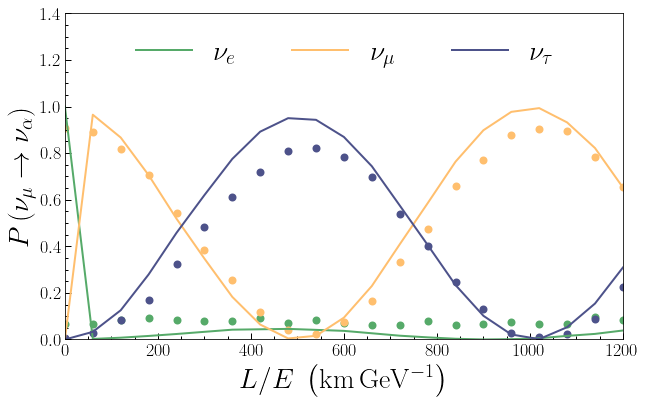

In [23]:
labels = [r'$\nu_{e}$', r'$\nu_{\mu}$', r'$\nu_{\tau}$', ]
cs     = ['#56aa69',     '#ffbf6e',      '#4d528a']
qc_results = np.load('three_neutrino_qc.npy') # Load results from actual quantum computer
plt.figure(figsize=[10,6])
for i, (c, lab) in enumerate(zip(cs, labels)):
    plt.scatter(loee, qc_results[i], color=c)
    plt.plot(loee, sim_results[i], label=lab, color=c)
plt.legend(fontsize=28, ncol=3,loc='upper center', frameon=False)
plt.xlim(0, 1200)
plt.ylim(0, 1.4)
plt.xlabel(r'$L/E~\left(\rm{km}\,\rm{GeV}^{-1}\right)$')
plt.ylabel(r'$P\left(\nu_{\mu}\rightarrow\nu_{\alpha}\right)$')
plt.show()

## 3) Probabilistically flip some bits

Let's look at how this would look for a single instance of counts

In [28]:
sim_results_error.T

array([[0., 1.],
       [0., 0.],
       [0., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 1.]])

In [ ]:
comp_to_mass       = [[a,b,c,0],[d,e,f,0],[g,h,i,0],[0,0,0,1]]
mass_to_comp       = comp_to_mass.T
results            = {'00':n, '01':m, '10':k}
state_vec          = [n,m,k,0] # in comp basis
mass_state         = np.matmul(comp_to_mass, state.T)
mass_results       = {'00':nprime, '01':mprime, '10':kprime}
error_mass_results = make_error(mass_results) # {'00':nprimeprime, '01':mprimeprime, '10':kprimeprime, '11':l}
error_mass_state   = [nprimeprime, mprimeprime, kprimeprime, l]
error_comp_state   = np.matmul(mass_to_comp, error_mass_state.T)
error_comp_results = {...}

In [25]:
p0_01 = 0.05
p1_01 = 0.03
p0_10 = 0.01
p1_10 = 0.1

sim_results_error = np.full((2, n), np.nan) # premake array which we will fill with our results
container         = np.full((2, n), np.nan) # premake array which we will fill with our results
start = 0
for key, val in counts.items():
    for i in range(val):
        container[:,i+start] = [x for x in str(key)]
    start += val
zero_mask0 = np.where(container[0]==0)[0]
zero_mask1 = np.where(container[1]==0)[0]
one_mask0  = np.where(container[0]==1)[0]
one_mask1  = np.where(container[1]==1)[0]
rand_ns0   = np.random.rand(len(zero_mask0)) # Make some random numbers between 0 and 1
rand_ns1   = np.random.rand(len(zero_mask1)) # Make some random numbers between 0 and 1
rand_ns2   = np.random.rand(len(one_mask0)) # Make some random numbers between 0 and 1
rand_ns3   = np.random.rand(len(one_mask1)) # Make some random numbers between 0 and 1

sim_results_error[0][zero_mask0] = np.where(rand_ns0>p0_01, container[0][zero_mask0], 1-container[0][zero_mask0])
sim_results_error[1][zero_mask1] = np.where(rand_ns1>p1_01, container[1][zero_mask1], 1-container[1][zero_mask1])
sim_results_error[0][one_mask0]  = np.where(rand_ns2>p0_10, container[0][one_mask0],  1-container[0][one_mask0])
sim_results_error[1][one_mask1]  = np.where(rand_ns3>p1_10, container[1][one_mask1],  1-container[1][one_mask1])

counts_error = {'11':0, '00':0, '01':0, '10':0}
for entry in sim_results_error.T: # gather things back into a dictionary
    key = str(int(entry[0]))+str(int(entry[1]))
    counts_error[key] += 1
print(counts)
print(counts_error)

{'00': 386, '01': 6525, '10': 3089}
{'11': 379, '00': 1024, '01': 5585, '10': 3012}


Now let's make this into a function for easy use

In [115]:
def make_counts_error(counts, p0_01=0.05, p1_01=0.03, p0_10=0.01, p1_10=0.1):
    sim_results_error = np.full((2, n), np.nan) # premake array which we will fill with our results
    container         = np.full((2, n), np.nan) # premake array which we will fill with our results
    start = 0
    for key, val in counts.items():
        for i in range(val):
            container[:,i+start] = [x for x in str(key)]
        start += val
    zero_mask0 = np.where(container[0]==0)[0]
    zero_mask1 = np.where(container[1]==0)[0]
    one_mask0  = np.where(container[0]==1)[0]
    one_mask1  = np.where(container[1]==1)[0]
    rand_ns0   = np.random.rand(len(zero_mask0)) # Make some random numbers between 0 and 1
    rand_ns1   = np.random.rand(len(zero_mask1)) # Make some random numbers between 0 and 1
    rand_ns2   = np.random.rand(len(one_mask0)) # Make some random numbers between 0 and 1
    rand_ns3   = np.random.rand(len(one_mask1)) # Make some random numbers between 0 and 1

    sim_results_error[0][zero_mask0] = np.where(rand_ns0>p0_01, container[0][zero_mask0], 1-container[0][zero_mask0])
    sim_results_error[1][zero_mask1] = np.where(rand_ns1>p1_01, container[1][zero_mask1], 1-container[1][zero_mask1])
    sim_results_error[0][one_mask0]  = np.where(rand_ns2>p0_10, container[0][one_mask0],  1-container[0][one_mask0])
    sim_results_error[1][one_mask1]  = np.where(rand_ns3>p1_10, container[1][one_mask1],  1-container[1][one_mask1])

    counts_error = {'11':0, '00':0, '01':0, '10':0}
    for entry in sim_results_error.T: # gather things back into a dictionary
        key = str(int(entry[0]))+str(int(entry[1]))
        counts_error[key] += 1
    return counts_error

Now we can rerun the QC simulator, adding in errors by hand at every step

In [120]:
loee = np.linspace(0, 1200, 21)
shots = 10000
sim_results = np.zeros((4,len(loee)))
sim_results_error = np.zeros((4,len(loee)))
for i, LE in enumerate(loee):
    tno = ThreeNuOscillator('numu')
    tno.apply_rotation(param=paper_PMNS_params)
    tno.propoagate(LE)
    tno.apply_rotation(param=paper_PMNS_dagger_params)
    tno.measure()
    job = execute(tno.qc, Aer.get_backend('qasm_simulator'), shots=shots)
    counts = job.result().get_counts(tno.qc)
    counts_error = make_counts_error(counts, p0_01=6.11e-3, p1_01=1.12e-01, p0_10=0.02, p1_10=1.12e-01)
    for j, (key, val) in enumerate(sorted(counts.items())):
        sim_results[j, i] = float(val)/n
    for j, (key, val) in enumerate(sorted(counts_error.items())):
        sim_results_error[j, i] = float(val)/n

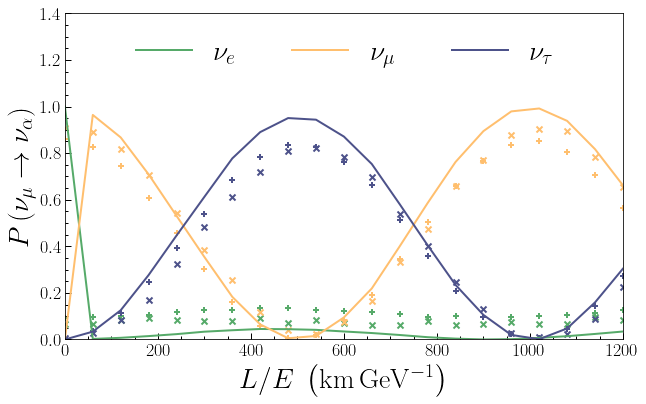

In [122]:
labels = [r'$\nu_{e}$', r'$\nu_{\mu}$', r'$\nu_{\tau}$', ]
cs     = ['#56aa69',     '#ffbf6e',      '#4d528a']
qc_results = np.load('three_neutrino_qc.npy') # Load results from actual quantum computer
plt.figure(figsize=[10,6])
for i, (c, lab) in enumerate(zip(cs, labels)):
    plt.scatter(loee, qc_results[i], color=c, marker='x')
    plt.scatter(loee, sim_results_error[i], color=c, marker='+')
    plt.plot(loee, sim_results[i], label=lab, color=c)
plt.legend(fontsize=28, ncol=3,loc='upper center', frameon=False)
plt.xlim(0, 1200)
plt.ylim(0, 1.4)
plt.xlabel(r'$L/E~\left(\rm{km}\,\rm{GeV}^{-1}\right)$')
plt.ylabel(r'$P\left(\nu_{\mu}\rightarrow\nu_{\alpha}\right)$')
plt.show()

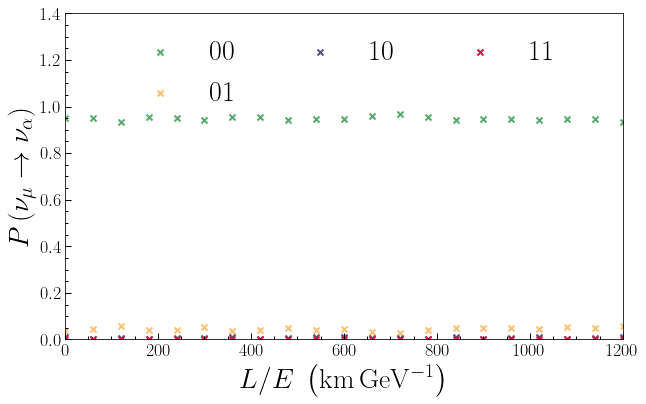

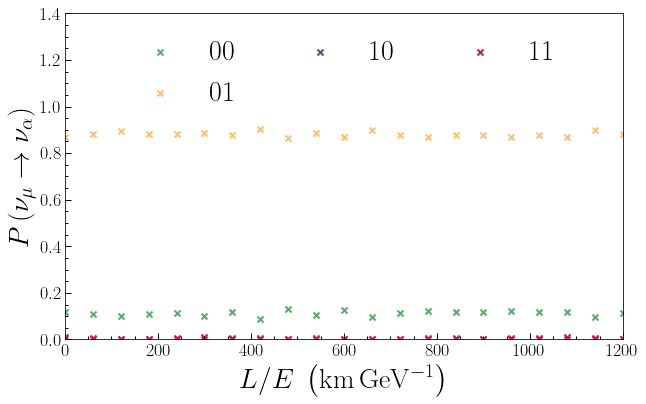

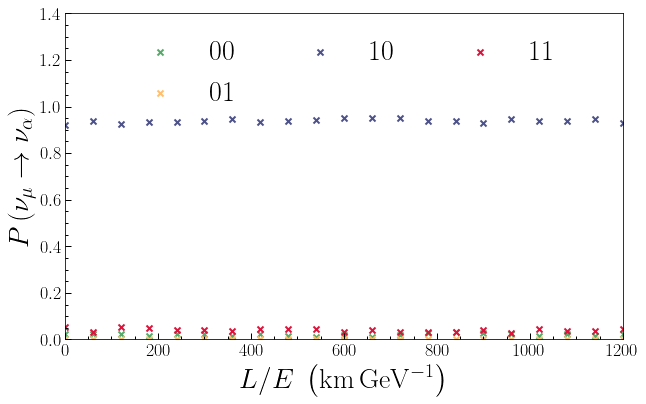

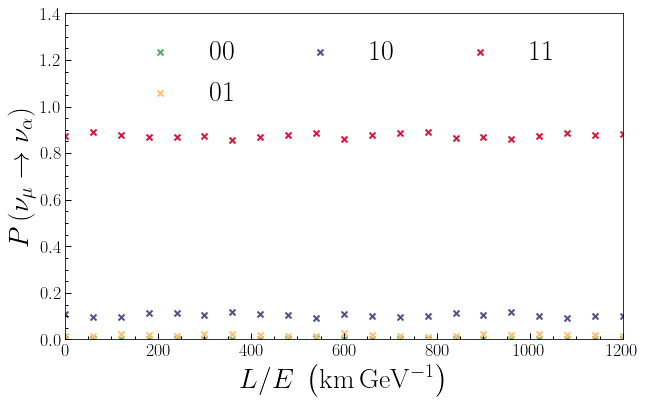

In [56]:
counts = {'00':1, '10':1, '01':1, '11':1}
labels = sorted(counts.keys())
cs     = ['#56aa69',     '#ffbf6e',      '#4d528a', 'crimson']
for init_state in ['nue', 'numu', 'nutau', 'nus']:
    qc_results = np.load('error_check_%s.npy' % init_state) # Load results from actual quantum computer
    plt.figure(figsize=[10,6])
    for i, (c, lab) in enumerate(zip(cs, labels)):
        plt.scatter(loee, qc_results[i], color=c, marker='x', label=lab)
    plt.legend(fontsize=28, ncol=3,loc='upper center', frameon=False)
    plt.xlim(0, 1200)
    plt.ylim(0, 1.4)
    plt.xlabel(r'$L/E~\left(\rm{km}\,\rm{GeV}^{-1}\right)$')
    plt.ylabel(r'$P\left(\nu_{\mu}\rightarrow\nu_{\alpha}\right)$')
    plt.show()

In [139]:
out_matrix = np.full((4,4), np.nan)
for i, init_state in enumerate(['nue', 'numu', 'nutau', 'nus']):
    qc_results = np.load('error_check_%s.npy' % init_state) # Load results from actual quantum computer
    out_matrix[i] = np.mean(qc_results, axis=1)
print(np.sum(out_matrix, axis=1))

[1. 1. 1. 1.]


In [140]:
def error_matrix(params):
    
    r'''
    returns error matrix
    
    params
    ______
    params (tuple): tuple of probablilities of flipping bits
    
    returns
    _______
    mat (np.ndarray): error matrix
    '''
    
    f0_01, f0_10, f1_01, f1_10 = params
#     f0_10 = f0_01 # Uncomment to return to two paramete case from paper
#     f1_10 = f1_01
    
    M00 = (1-f0_01)*(1-f1_01) + f0_01*f0_10 + f1_01*f1_10
    M10 = (1-f0_01 - f1_10) * f1_01
    M20 = (-f0_10 + 1-f1_01) * f0_01
    M30 = f0_01*f1_01
    
    M01 = (1-f0_01 - f1_01) * f1_10
    M11 = (1-f0_01)*(1-f1_10) + f0_01*f0_10 + f1_01*f1_10
    M21 = f0_01*f1_10
    M31 = (-f0_10 + 1-f1_10) * f0_01
    
    M02 = (-f0_01 + 1-f1_01) * f0_10
    M12 = f0_10*f1_01
    M22 = (1-f0_10)*(1-f1_01) + f0_01*f0_10 + f1_01*f1_10
    M32 = (1-f0_10 - f1_10) * f1_01
    
    M03 = f0_10*f1_10
    M13 = (-f0_01 + 1-f1_10) * f0_10
    M23 = (1-f0_10 - f1_01) * f1_10
    M33 = (1-f0_10)*(1-f1_10) + f0_01*f0_10 + f1_01*f1_10
    
    mat = np.array(
                   [
                       [M00, M01, M02, M03],
                       [M10, M11, M12, M13],
                       [M20, M21, M22, M23],
                       [M30, M31, M32, M33],
                   ]
                  )
    return mat

In [141]:
def error_matrix_likelihood(params, target_matrix):
    # make a box
    if np.any([p>1 for p in params]):
        value = np.inf
    elif np.any([p<0 for p in params]):
        value = np.inf
    else:
        mat   = error_matrix(tuple(params))
        value = np.sum([np.abs(np.abs(mat[i,j]-target_matrix[i,j])) for i in range(4)
                                                                    for j in range(4)
                       ]
                 )
    return value

In [142]:
# randomly select set of params
n_guesses                   = 100
first_guesses               = [tuple(np.random.rand((4))) for i in range(n_guesses)]
llhs                        = [error_matrix_likelihood(guess, out_matrix) for guess in first_guesses] # evaluate likelihood for each guess
sorted_llhs, sorted_guesses = zip(*sorted(zip(llhs, first_guesses)))
best_guess                  = np.array(sorted_guesses[0]) # pick the guess that gave the lowest likelihood value
print(best_guess)
error_fit                   = minimize(error_matrix_likelihood, best_guess, method='L-BFGS-B', tol=1e-40, args=out_matrix) # run the minimizer starting from the best guess
error_params                = error_fit.x
inv_error                   = linalg.inv(error_matrix(best_guess))
# inv_error                   = linalg.inv(error_matrix(tuple(error_params)))
print(error_params)

[0.16916317 0.11807287 0.11664015 0.25577371]
[0.16916317 0.11807287 0.11664015 0.25577371]


[-0.23607865 -0.22959338 -0.19302016 -0.14884522 -0.12341461 -0.09137245
 -0.06483968 -0.00956069 -0.02572691 -0.00508638 -0.03545293 -0.0686021
 -0.10440172 -0.11554182 -0.1842164  -0.20502775 -0.21769455 -0.23332846
 -0.23549272 -0.16287838 -0.15080501]
[1.39925201 1.37071105 1.25629422 1.08108255 0.8247159  0.57730642
 0.37822032 0.15817235 0.04330183 0.01876912 0.10103141 0.23797206
 0.50211293 0.7182412  1.00877007 1.18786342 1.35102786 1.39001486
 1.38309736 1.19760978 1.00130655]
[0.01389261 0.04008954 0.10582578 0.2009054  0.38861952 0.5853527
 0.74070343 0.86162408 0.97725784 0.9935624  0.95003877 0.84535435
 0.6537996  0.48874005 0.30164096 0.15904136 0.03813746 0.01966822
 0.0332002  0.1041033  0.27249247]


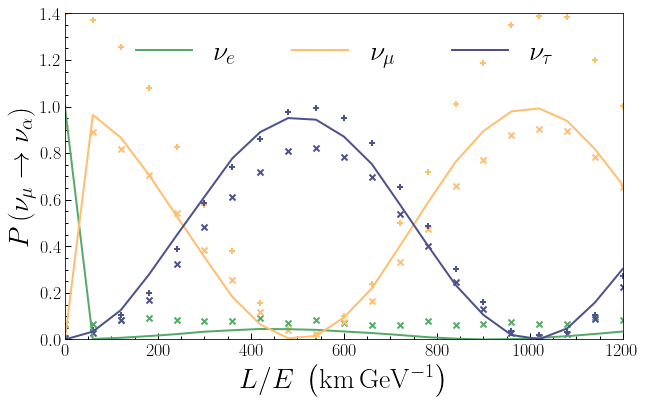

In [143]:
labels = [r'$\nu_{e}$', r'$\nu_{\mu}$', r'$\nu_{\tau}$', ]
cs     = ['#56aa69',     '#ffbf6e',      '#4d528a']
qc_results           = np.load('three_neutrino_qc.npy') # Load results from actual quantum computer
corrected_qc_results = np.array([np.matmul(inv_error, x.T,).T for x in qc_results.T]).T
plt.figure(figsize=[10,6])
for i, (c, lab) in enumerate(zip(cs, labels)):
    print(corrected_qc_results[i])
    plt.scatter(loee, qc_results[i], color=c, marker='x')
    plt.scatter(loee, corrected_qc_results[i], color=c, marker='+')
    plt.plot(loee, sim_results[i], label=lab, color=c)
plt.legend(fontsize=28, ncol=3,loc='upper center', frameon=False)
plt.xlim(0, 1200)
plt.ylim(0, 1.4)
plt.xlabel(r'$L/E~\left(\rm{km}\,\rm{GeV}^{-1}\right)$')
plt.ylabel(r'$P\left(\nu_{\mu}\rightarrow\nu_{\alpha}\right)$')
plt.show()

In [9]:
pts = [1,2,3,-3,-2,0.3,1,4,23,4,0,2343,43,3,4]
non_zero_points = [x**2 for x in pts if x>0]